In [1]:
import numpy as np  
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib.axes as axes
import seaborn as sns
from pandas.core.frame import DataFrame

from scipy.fftpack import fft,ifft
from tqdm import tqdm

from matplotlib.figure import Figure
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

from matplotlib.ticker import Locator
from matplotlib.ticker import MaxNLocator

In [2]:
csv_filename = "Breath.csv"
df = pd.read_csv(csv_filename, names=["time", "us", "acc","ws","label"])
df.head(5)

,time,us,acc,ws,label
0,17:18:04.965,1027168,-0.048445,NaN,NaN
1,17:18:04.999,1058904,-0.059468,NaN,NaN
2,17:18:05.036,1090640,-0.038652,NaN,NaN
3,17:18:05.071,1122372,-0.049056,NaN,NaN
4,17:18:05.071,1154108,-0.051094,NaN,NaN


In [3]:
acc_list = np.array(df["acc"])
acc_time = np.array(df["time"])
acc_us = np.array(df["us"])
acc_ms = [int(ms) for ms in acc_us/1000]
acc_list = acc_list*1000
acc_mean = np.mean(acc_list)
acc_std  = np.std(acc_list)
acc_mean_str = "{:.2f}".format(acc_mean)
acc_std_str = "{:.2f}".format(acc_std)
print("the acc dist mean:%.2fmg and std:%.2fmg" %(acc_mean,acc_std))

the acc dist mean:-54.18mg and std:6.41mg


# 加速度传感器矫正

100%|███████████████████████████████████████████████████████████████████████████| 9504/9504 [00:00<00:00, 25754.24it/s]


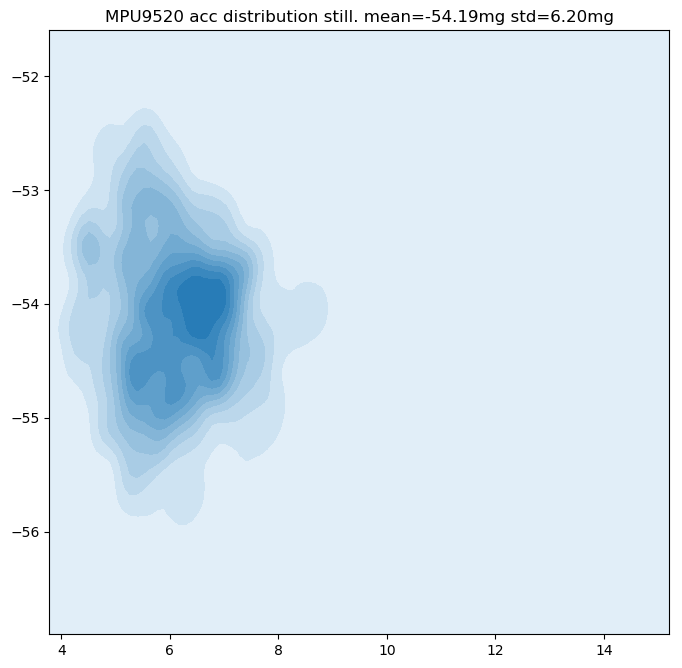

In [4]:
# 加速度传感器校准用
CONST_STATIC_WINDOW = 64
static_mean_list = []
static_std_list  = []
#遍历加速度，寻找传感器安静的时间段，记录它的avg和std
for k in tqdm(range(CONST_STATIC_WINDOW,acc_list.size,1)):
    acc_list_slice = acc_list[k-CONST_STATIC_WINDOW:k]
    acc_mean = np.mean(acc_list_slice)
    acc_std  = np.std(acc_list_slice)
    if acc_std < 20:
        static_std_list.append(acc_std)
        static_mean_list.append(acc_mean)
pass
static_mean = np.mean(static_mean_list)
static_std = np.mean(static_std_list)
static_mean_str = "{:.2f}".format(static_mean)
static_std_str = "{:.2f}".format(static_std)
# print(static_std_list)
bins=np.arange(np.min(static_std_list),np.max(static_std_list),0.1)
plt.figure(figsize=(8, 8), dpi=100)
ax = plt.subplot()
ax.set_xlim(np.min(static_std_list), np.max(static_std_list))
sns.kdeplot(static_std_list,static_mean_list,shade=True)
plt.title("MPU9520 acc distribution still. mean="+static_mean_str+"mg std="+static_std_str+"mg")
plt.savefig("static.png")

In [5]:
acc_list = acc_list - static_mean # 将加速度列表矫正到0

# 以秒为单位计算std和avg，找出最大的以判断时域波形刻度范围

100%|█████████████████████████████████████████████████████████████████████████████| 298/298 [00:00<00:00, 13543.65it/s]


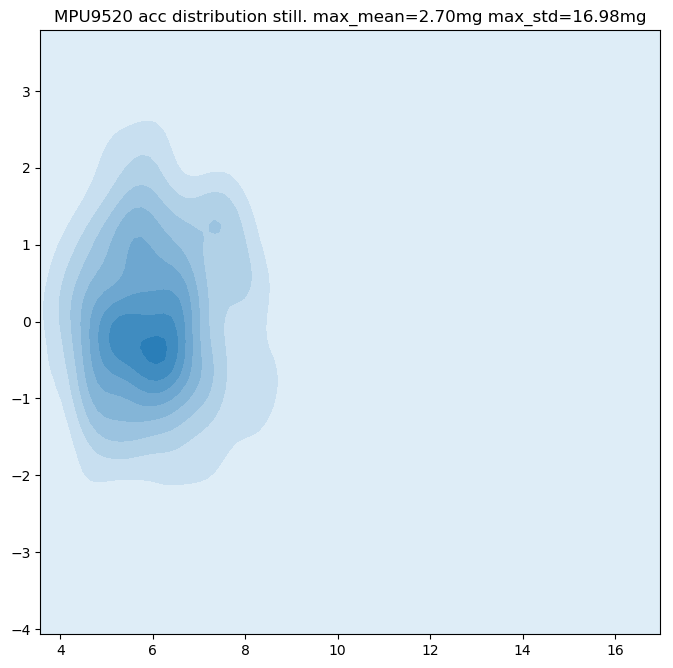

In [6]:
SECOND_WINDOW = 32# sample rate 32
second_mean_list = []
second_std_list  = []
acc_mean_max = float()
acc_std_max = float()
#遍历加速度，寻找传感器安静的时间段，记录它的avg和std
for k in tqdm(range(SECOND_WINDOW,acc_list.size,SECOND_WINDOW)):
    acc_list_slice = acc_list[k-SECOND_WINDOW:k-1]
    acc_mean_max = acc_mean_max if(acc_mean_max>np.mean(acc_list_slice)) else np.mean(acc_list_slice)
    acc_std_max  = acc_std_max if(acc_std_max>np.std(acc_list_slice)) else np.std(acc_list_slice)
    second_mean_list.append(np.mean(acc_list_slice))
    second_std_list.append(np.std(acc_list_slice))
pass

acc_mean_str = "{:.2f}".format(acc_mean_max)
acc_std_str = "{:.2f}".format(acc_std_max)
# print(static_std_list)
bins=np.arange(np.min(second_std_list),np.max(second_std_list),0.1)
plt.figure(figsize=(8, 8), dpi=100)
ax = plt.subplot()
ax.set_xlim(np.min(second_std_list), np.max(second_std_list))
sns.kdeplot(second_std_list,second_mean_list,shade=True)
plt.title("MPU9520 acc distribution still. max_mean="+acc_mean_str+"mg max_std="+acc_std_str+"mg")
plt.savefig("max_mean__max_std.png")

# 以1024个点为单位遍历一次，找FFT的直流分量大小

In [7]:
FFT = list()
for i in range(0,len(acc_list)):
#     if FFT_0<np.mean(acc_list[i:i+32]):
    FFT.append(np.mean(acc_list[i:i+1024]))
#     print(np.mean(acc_list[i:i+32]),i)
np.mean(FFT)

0.05424766658126199

# 开始画图

In [8]:
fig= Figure(figsize=[25.6,14.4],dpi=100,facecolor="black",edgecolor="#BEBEBE")
canvas = FigureCanvas(fig)
ax_chart_32s = fig.add_axes([100/2560,970/1440,1350/2560,420/1440])
ax_chart_1s = fig.add_axes([1507/2560,970/1440,372/2560,420/1440])

ax_violin = fig.add_axes([1507/2560,510/1440,372/2560,412/1440])
ax_violins = fig.add_axes([100/2560,510/1440,1350/2560,412/1440])

ax_FFT = fig.add_axes([100/2560,50/1440,2360/2560,406/1440])

ax_video = fig.add_axes([1929/2560,496/1440,531/2560,944/1440])
canvas.print_figure("123.png")
fig.savefig("sample.png",facecolor=fig.get_facecolor(),edgecolor=fig.get_edgecolor())

# 使用seaborn画violin

In [ ]:
#plt.savefig("sample.png")
CONST_ACC_MAX = math.pow(2, int(math.log(acc_mean_max + 4 * acc_std_max, 2)) + 1)
# define the limits automatically
#设置时域图和violin的y坐标的上下限
CONST_ACC_MIN = -CONST_ACC_MAX
CONST_CHART_WINDOW = 1024
CONST_FFT_WINDOW = 1024
CONST_VIOLIN_WINDOW = 32
CONST_VIOLINS_WINDOW = 1024
CONST_VIOLINS_DIV = 32
CONST_SAMP_RATE = 32  # 采样率
CONST_COLOR_STD_LMT = 128
CONST_BLUE_RGB = [0, 0, 255]
CONST_WHITE_RGB = [255, 255, 255]
CONST_FFT_MIN = 0
CONST_FFT_MAX = 2

def whiten(ax, title):
    spine = ['bottom', 'top', 'right', 'left']
    for tickline in ax.xaxis.get_ticklines():
        tickline.set_color('white')
    for ticklabel in ax.xaxis.get_ticklabels():
        ticklabel.set_color('white')
    for tickline in ax.yaxis.get_ticklines():
        tickline.set_color('white')
    for ticklabel in ax.yaxis.get_ticklabels():
        ticklabel.set_color('white')
    for orien in spine:
        ax.spines[orien].set_color('black')
    ax.set_facecolor("black")  # grey
    title.set_color("white")
    title.set_fontsize('large')


def whiten_violin(result):
    for key in result:
        if key is not 'bodies':
            result[key].set_color('')

for k in tqdm(range( acc_list.size)):  # start form 1024, shift 8 every time
    #list.index()
    ax_violin.set_ylim(CONST_ACC_MIN, CONST_ACC_MAX)
    ax_violins.set_ylim(CONST_ACC_MIN, CONST_ACC_MAX)
    

    # 绘制时域32s图
    slice_start = k - CONST_FFT_WINDOW
    slice_end = k
    if slice_start < 0:
        slice_start = 0
    acc_slice = acc_list[slice_start:slice_end]
    acc_slice = np.lib.pad(acc_slice, (CONST_CHART_WINDOW - acc_slice.size, 0), 'constant', constant_values=(0, 0))

    ax_chart_32s.plot(acc_slice, 'w')  # '--w'
    ax_chart_32s.set_ylim(CONST_ACC_MIN, CONST_ACC_MAX)
    title = ax_chart_32s.set_title("Realtime chart,Time: " + str(acc_time[k]) + "  Reading: " + "{:.2f}".format(acc_list[k]) + "mg")
    whiten(ax_chart_32s, title)

    #绘制时域1s
    acc_slice_1s = acc_slice[-32:]
    ax_chart_1s.plot(acc_slice_1s,'w')
    ax_chart_1s.set_ylim(CONST_ACC_MIN, CONST_ACC_MAX)
    title = ax_chart_1s.set_title("Last one second")
    whiten(ax_chart_1s, title)
    
    # 绘制FFT图
    #########################################
    fft_abs = abs(fft(acc_slice))
    fft_norm = fft_abs / int(CONST_FFT_WINDOW)
    fft_half = fft_norm[:int(CONST_FFT_WINDOW / 2)]

    ax_FFT.bar(x=np.linspace(0, CONST_SAMP_RATE / 2, 513)[:-1],  # the first 128 points covers frequency from 0-4hz
                   height=fft_half,width=0.9,bottom=0,align="center",color="white")

    ax_FFT.xaxis.set_major_locator(MaxNLocator(nbins=20, prune='lower'))
    title = ax_FFT.set_title("FFT chart:0 - 16Hz")
    whiten(ax_FFT, title)
    ax_FFT.set_ylim(CONST_FFT_MIN, CONST_FFT_MAX)
    ax_FFT.set_xlim(0, 16)  # 0-4hz

    # 绘制violin图
    ##########################################
    slice_start = k - CONST_VIOLIN_WINDOW
    slice_end = k
    if slice_start < 0:
        slice_start = 0
    acc_slice = acc_list[slice_start:slice_end]
    acc_slice = np.lib.pad(acc_slice, (CONST_VIOLIN_WINDOW - acc_slice.size, 0), 'constant', constant_values=(0, 0))
    acc_slice_dataset = pd.DataFrame(acc_slice)
    violin_mean = acc_slice_dataset[0].mean()
    violin_std = acc_slice_dataset[0].std()
    violin_mean_str = "{:.5f}".format(violin_mean)
    violin_std_str = "{:.5f}".format(violin_std)

    face_color = [(CONST_WHITE_RGB[i] - (CONST_WHITE_RGB[i] - CONST_BLUE_RGB[i]) * abs(violin_std / CONST_COLOR_STD_LMT)) / 255 for i in range(3)]
    for color in face_color:
        if color<0:
            color=0

    ###########seaborn violin#############
    violinplot_ax = sns.violinplot(x=acc_slice, color=face_color, ax=ax_violin, linewidth=0,orient="v")
    ax.grid(False)
    
    title = ax_violin.set_title("Realtime violin. Mean: " + violin_mean_str + "  Std: " + violin_std_str)
    ax_violin.yaxis.set_major_locator(MaxNLocator(nbins=16, prune='lower'))
    whiten(ax_violin, title)

    # 绘制violins图
    ################################
    slice_start = k - CONST_VIOLINS_WINDOW
    slice_end = k
    if slice_start < 0:
        slice_start = 0
    acc_slice = acc_list[slice_start:slice_end]
    acc_slice = np.lib.pad(acc_slice, (CONST_VIOLINS_WINDOW - acc_slice.size, 0), 'constant', constant_values=(0, 0))

    violins_dataset = pd.DataFrame(
        [acc_slice[int(t - CONST_VIOLINS_DIV):int(t)] for t in list(np.linspace(0, 1024, CONST_VIOLINS_DIV + 1)[1:])])
    color_list = []
    for row in range(CONST_VIOLINS_DIV):
        violins_color = abs(violins_dataset.loc[row, :].std())
        violins_color_relative = violins_color / CONST_COLOR_STD_LMT
        if violins_color_relative>1:
            violins_color_relative=1
        color_list.append(
            [(CONST_WHITE_RGB[i] - (CONST_WHITE_RGB[i] - CONST_BLUE_RGB[i]) * violins_color_relative) / 255 for i in range(3)])
        # rgba in float 0-1 form
    violins_result = ax_violins.violinplot(dataset=violins_dataset)
    ax_violins.yaxis.set_major_locator(MaxNLocator(nbins=(CONST_ACC_MAX / 4) + 1, prune='lower'))
    for pc in range(len(violins_result['bodies'])):
        violins_result['bodies'][pc].set_facecolor(color_list[pc])
        violins_result['bodies'][pc].set_edgecolor("white")
        
    title = ax_violins.set_title("History violins")
    ax_violins.yaxis.set_major_locator(MaxNLocator(nbins=16, prune='lower'))
    whiten(ax_violins, title)
    whiten_violin(violins_result)
    # 调整 video框
    ax_video.set_facecolor("black")
    spine = ['bottom', 'top', 'right', 'left']
    for orien in spine:
        ax_video.spines[orien].set_color('white')
    ax_video.axis(option=False)
    # save figs
    fig.savefig("dir_frames_breath/" + str(10000000000 + acc_ms[k]) + '.png', facecolor=fig.get_facecolor(), edgecolor='none')
    ax_chart_32s.cla()
    ax_chart_1s.cla()
    ax_FFT.cla()
    ax_violin.cla()
    ax_violins.cla()